In [175]:
# === Standard Library ===
import json
import os
import sys
from typing import Any, Dict, List, Optional, Union, TypedDict, Annotated
from collections import defaultdict

# === Data Handling ===
import pandas as pd
import re

# === NLP Models ===
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel

# === LangGraph Core ===
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# === LangChain & LLM ===
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama
import ollama  # used directly in custom LLM calls

# === Validation ===
from pydantic import BaseModel


In [220]:
from cfa_parsinv_v3 import *

def get_node_by_path(root: BookNode, path: str) -> BookNode:
    node = root
    for part in path.split(" -> "):
        node = node[part]
    return node


flat_sections = cfa_book.flatten_paths(levels=(3, 4))

# get_node_by_path(cfa_book,res[0]).content



def find_relevant_sections(
    query: str,
    tree: BookNode,
    top_k: int = 10,
    score_threshold1: float = 0.5,
    score_threshold2: float = 0.3,
    model_name: str = 'all-MiniLM-L6-v2',
    return_content: bool = False
) -> Union[List[str], Dict[str, str]]:
    """
    Searches level-3 & level-4 headings by semantic similarity,
    falling back to level-2 (modules) if nothing passes threshold1.

    If return_content=False: returns list of paths.
    If return_content=True: returns dict { path: full_text }.
    """
    # 0) prepare flattened paths
    flat_sec = tree.flatten_paths(levels=(3,4))
    flat_mod = tree.flatten_paths(levels=(2,))

    # 1) encode
    model = SentenceTransformer(model_name, device='mps')
    q_emb = model.encode(query, convert_to_tensor=True)
    sec_embs = model.encode(flat_sec, convert_to_tensor=True)

    # 2) chapter/subchapter matching
    scores = util.cos_sim(q_emb, sec_embs)[0]
    hits = sorted(
        [(i, float(s)) for i, s in enumerate(scores) if float(s) >= score_threshold1],
        key=lambda x: x[1], reverse=True
    )[:top_k]

    if hits:
        section_keys = [ flat_sec[i] for i, _ in hits ]
    else:
        # fallback to module‐level
        mod_embs = model.encode(flat_mod, convert_to_tensor=True)
        scores = util.cos_sim(q_emb, mod_embs)[0]
        hits = sorted(
            [(i, float(s)) for i, s in enumerate(scores) if float(s) >= score_threshold2],
            key=lambda x: x[1], reverse=True
        )[: top_k + 2]
        section_keys = [ flat_mod[i] for i, _ in hits ]

    if not return_content:
        return section_keys

    # build path->content map
    return {
        path: get_node_by_path(tree, path).content
        for path in section_keys
    }


In [215]:
path = "/Users/danielrubibreton/Desktop/PythonStuff/hface/all-MiniLM-L6-v2"

In [216]:
tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModel.from_pretrained(path)

In [219]:
%%time
res = find_relevant_sections("The Log-Lin Model", cfa_book)
res

CPU times: user 651 ms, sys: 400 ms, total: 1.05 s
Wall time: 2.31 s


['1. Quantitative Methods -> 10. Simple Linear Regress -> 2. Functional Forms for Simple Linear Regression -> 1. The Log-Lin Model',
 '1. Quantitative Methods -> 10. Simple Linear Regress -> 2. Functional Forms for Simple Linear Regression -> 2. The Lin-Log Model',
 '1. Quantitative Methods -> 10. Simple Linear Regress -> 2. Functional Forms for Simple Linear Regression -> 3. The Log-Log Model']

In [14]:
class LocalLLM:
    def __init__(
        self,
        model: str = "deepseek-r1:1.5b",
        temperature: float = 0,
        max_tokens: Optional[int] = None,
    ):
        self.model = model
        self.temperature = temperature


    def invoke(self, prompt: str) -> str:
        messages = [{"role": "user", "content": prompt}]
        response = ollama.chat(
            model=self.model,
            messages=messages,
            options={
                "temperature": self.temperature,
                "num_thread": 10,
                "low_vram": False,
            } 
        )
        return response["message"]["content"].split("</think>")[-1].strip("\n")


In [10]:
llm = LocalLLM()

In [22]:

# -------------------------------------------------------------------------
# 2. GraphState definition
# -------------------------------------------------------------------------
class GraphState(TypedDict):
    query: str
    retrieved_sections: Optional[Any]       # Will hold either List[str] or str
    response: Optional[str]
    messages: Annotated[List[Dict[str, str]], add_messages]
    goto: Optional[str]          # Used by the confirm node to drive conditional edges
    context: str


# -------------------------------------------------------------------------
# 3. Retrieval node (unchanged)
# -------------------------------------------------------------------------

def user_query_node(state: GraphState) -> GraphState:
    query = state["query"]
    # find_relevant_sections(query) returns List[str]

    
    return {
        "messages": [HumanMessage(content=query)]
    }



def retrieval_node(state: GraphState) -> GraphState:
    query = state["query"]
    # find_relevant_sections(query) returns List[str]
    section_list = find_relevant_sections(query)

    
    return {
        "messages": [SystemMessage(content=section_list)],
        "retrieved_sections": section_list
    }


# -------------------------------------------------------------------------
# 4. Confirm node using interrupt()
# -------------------------------------------------------------------------

def confirm_node(state: GraphState) -> Dict[str, Any]:
    sections = state["retrieved_sections"]

    # 1) Exactly one → skip confirmation
    if len(sections) == 1:
        return {
            "messages": [
                SystemMessage(content=f"Only one section found: {sections[0]}. Skipping confirmation.")
            ],
            "retrieved_sections": sections,
            "goto": "full_retrieval"
        }

    # 2) None → ask user to rephrase query
    if not sections:
        new_q = interrupt({
            "prompt": "I couldn't find any sections matching your question. Please rephrase or clarify your query."
        })
        return {
            "messages": [SystemMessage(content=f"User provided new query: {new_q}")],
            "query": new_q,
            "goto": "retrieve"
        }

    # 3) Multiple → present numbered options
    opts = "\n".join(f"{i+1}. {sec}" for i, sec in enumerate(sections))
    choice = interrupt({
        "prompt": (
            "I found multiple relevant sections. Please select one by number:\n\n"
            f"{opts}\n\nReply with 1, 2, 3, etc."
        )
    })

    # validate
    try:
        idx = int(choice.strip()) - 1
        if idx < 0 or idx >= len(sections):
            raise ValueError()
    except ValueError:
        return {
            "messages": [SystemMessage(content=f"Invalid choice '{choice}'. Let me try again.")],
            "goto": "confirm"
        }

    # valid selection
    picked = sections[idx]
    return {
        "messages": [
            SystemMessage(content=f"User selected option {idx+1}: {picked}")
        ],
        "retrieved_sections": [picked],
        "goto": "full_retrieval"
    }

# -------------------------------------------------------------------------
# 5. Full retrieval node (unchanged)
# -------------------------------------------------------------------------
def full_retrieval_node(state: GraphState) -> GraphState:
    section_list = state["retrieved_sections"]  # This is still List[str]
    all_text = []
    for sec in section_list:
        book, chap = sec.split(" -> ", 1)
        text = book_json[book][chap]
        full_ctx.append(f"Book & Chapter: {sec}\n{text}")
        
    concatenated = "\n".join(all_text)

    
    return {
        "context": concatenated,
        "messages": [SystemMessage(content="Fetched full text for all candidate sections.")]
    }


# -------------------------------------------------------------------------
# 6. Response node (unchanged)
# -------------------------------------------------------------------------
def response_node(state: GraphState) -> GraphState:
    context_text = state["context"]  # Now a big string
    query = state["query"]
    prompt = (
        "Below are the relevant CFA curriculum sections:\n\n"
        f"{context_text}\n\n"
        f"Question: {query}\n\n"
        "Please answer in a concise, yet complete manner, citing the relevant sections as needed."
    )
    llm_answer = llm.invoke(prompt)

    return {
        "response": llm_answer,
        "messages": [AIMessage(content=llm_answer)]
    }


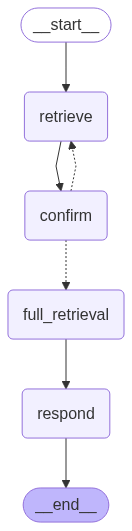

In [24]:
graph = (
    StateGraph(GraphState)
    .add_node("retrieve",       retrieval_node)
    .add_node("confirm",        confirm_node)
    .add_node("full_retrieval", full_retrieval_node)
    .add_node("respond",        response_node)
    
    .add_edge(START,            "retrieve")
    .add_edge("retrieve",       "confirm")
    .add_conditional_edges(
        "confirm",
        path=lambda out: out.get("goto"),
        path_map={"full_retrieval":"full_retrieval","retrieve":"retrieve"},
    )
    .add_edge("full_retrieval", "respond")
    .add_edge("respond",         END)
    .compile()
)

graph

In [ ]:
# assume `graph` is already defined and compiled as in your notebook

while True:
    user_query = input("You: What is the difference between Venture capital and Private Equity?")
    if user_query.strip().lower() == "exit":
        print("Exiting chat. Goodbye!")
        break

    # build the LangGraph input
    state = {"messages": [{"role": "user", "content": user_query}]}
    
    # stream the response tokens as they arrive
    for msg_chunk, meta in graph.stream(
        state,
        stream_mode="messages"
    ):
        print(meta.get("langgraph_node"))
        # only print from your 'respond' node
        if meta.get("langgraph_node") == "respond" and msg_chunk.content:
            print(msg_chunk.content, end="", flush=True)
    print()  # newline after the full response


In [56]:
query = "what is the capital structure of Modigliani–Miller?"
sections = find_relevant_sections(query)
sections

['Corporate Issuers -> 4.Modigliani–Miller Capital Structure Propositions']

In [65]:
def remove_numbers(text: str) -> str:
    return re.sub(r'\d+', '', text)

In [66]:
list_text = "\n".join(f"{i+1}. {remove_numbers(sec)}" for i, sec in enumerate(sections))
list_text

'1. Corporate Issuers -> .Modigliani–Miller Capital Structure Propositions'

In [78]:
llm_prompt = (
    f"The user asked the following question:\n"
    f"'{query}'\n\n"
    "Below is a numbered list of CFA curriculum sections.\n"
    "Your task is to select ONLY the numbers of the sections that are directly and precisely relevant to the question.\n\n"
    "VERY IMPORTANT:\n"
    "- ONLY use section numbers from the list below.\n"
    "- Do NOT make up new sections or topics.\n"
    "- If none of the sections are clearly relevant, reply only with: 'uncertain'.\n"
    "- Your answer must be a comma-separated list of the section numbers only (e.g., '1, 3, 5')\n\n"
    f"Sections:\n{list_text}"
)


print(llm_prompt)
llm_response = llm.invoke(llm_prompt).strip().lower()

The user asked the following question:
'what is the capital structure of Modigliani–Miller?'

Below is a numbered list of CFA curriculum sections.
Your task is to select ONLY the numbers of the sections that are directly and precisely relevant to the question.

⚠️ VERY IMPORTANT:
- ONLY use section numbers from the list below.
- Do NOT make up new sections or topics.
- If none of the sections are clearly relevant, reply only with: 'uncertain'.
- Your answer must be a comma-separated list of the section numbers only (e.g., '1, 3, 5')

Sections:
1. Corporate Issuers -> .Modigliani–Miller Capital Structure Propositions


In [79]:
llm_response

'the correct section is 1.\n\nuncertain'

In [80]:
list({int(i) for i in re.findall("\d+", llm_response)})

[1]